### LSTM in PyTorch
From <a href ="https://www.kaggle.com/purplejester/a-simple-lstm-based-time-series-classifier">here</a>.

In [62]:
from multiprocessing import cpu_count
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

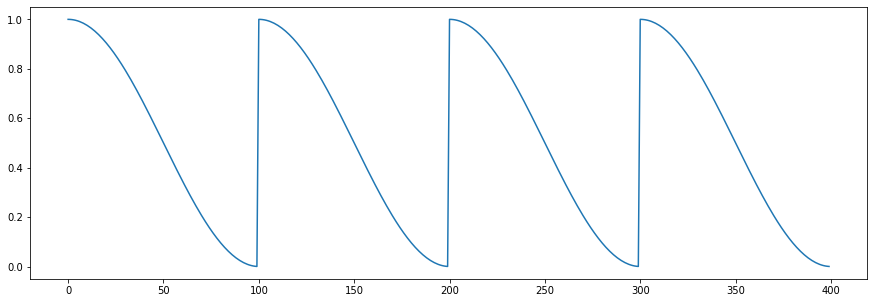

In [21]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

In [22]:
seed = 1
np.random.seed(seed)
torch.cuda.set_device(0)  # if you have more than one CUDA device
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

train_window = 12
batch_size = 1
lr=.001
n_epochs = 200
patience = 1000

In [24]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [25]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

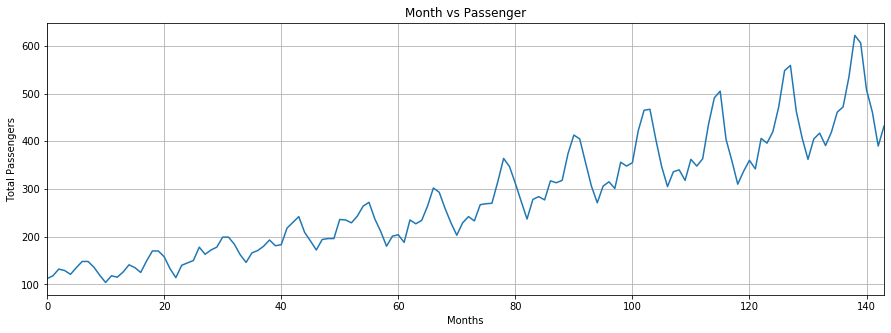

In [26]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [27]:
all_data = flight_data['passengers'].values.astype(float)

In [28]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [29]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [30]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [33]:
class TimeSeriesDataset(Dataset):
    
    """Generic dataset class for tabular data.
    """
    
    def __init__(self, X, y, time_lags):
        self.X = X
        self.y = y
        self.time_lags = time_lags

    def __len__(self):
        return len(self.X) - self.time_lags

    def __getitem__(self, idx):
        shifted_idx = idx + self.time_lags
        return np.reshape(self.X[idx:shifted_idx], (self.time_lags, -1)), self.y[shifted_idx]
    
dataset = TimeSeriesDataset(train_data_normalized, train_data_normalized, train_window)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)   

In [34]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

### Building the LSTM

##### LSTM module
```nn.LSTM``` inputs must be shaped according to *(seq_len, batch, input_size)*. This can be changed be setting ```batch_first``` to ```True```. In this case, the input data is shaped as *(batch, seq, feature)*.

##### Linear/Feed-forward module
The output features must be equal to the shape of the input features, except for the last dimension.

In [35]:
class LSTM(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [56]:
model = LSTM()
iterations_per_epoch = len(dataloader)

In [57]:
model = model.cuda()
criterion = nn.MSELoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))
trials = 0
best_rmse = 100000
print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    epoch_loss = 0
    
    for i, (x_batch, y_batch) in enumerate(dataloader):
        
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        epoch_loss += loss
        loss.backward()
        opt.step()
        
    epoch_loss = epoch_loss / len(dataloader)
    
    model.eval()
    square_error, total = 0, 0
    for x_val, y_val in dataloader:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        preds = model(x_val)
        total += y_val.size(0)
        square_error += ((preds - y_val)**2).sum().item()
    
    rmse = np.sqrt(square_error / total)

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. RMSE.: {rmse:.4f}')

    if rmse > best_rmse:
        trials = 0
        best_rmse = rmse
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with rmse: {best_rmse:.4f}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training
Epoch:   1. Loss: 0.0811. RMSE.: 0.2166
Epoch:   2. Loss: 0.0386. RMSE.: 0.2303
Epoch:   3. Loss: 0.0415. RMSE.: 0.1959
Epoch:   4. Loss: 0.0367. RMSE.: 0.1827
Epoch:   5. Loss: 0.0412. RMSE.: 0.1856
Epoch:   6. Loss: 0.0332. RMSE.: 0.1754
Epoch:   7. Loss: 0.0374. RMSE.: 0.1646
Epoch:   8. Loss: 0.0280. RMSE.: 0.1607
Epoch:   9. Loss: 0.0330. RMSE.: 0.1489
Epoch:  10. Loss: 0.0231. RMSE.: 0.1468
Epoch:  11. Loss: 0.0227. RMSE.: 0.1250
Epoch:  12. Loss: 0.0179. RMSE.: 0.1296
Epoch:  13. Loss: 0.0210. RMSE.: 0.1759
Epoch:  14. Loss: 0.0157. RMSE.: 0.1187
Epoch:  15. Loss: 0.0215. RMSE.: 0.1236
Epoch:  16. Loss: 0.0137. RMSE.: 0.1091
Epoch:  17. Loss: 0.0182. RMSE.: 0.1112
Epoch:  18. Loss: 0.0117. RMSE.: 0.1054
Epoch:  19. Loss: 0.0170. RMSE.: 0.1116
Epoch:  20. Loss: 0.0112. RMSE.: 0.1777
Epoch:  21. Loss: 0.0149. RMSE.: 0.1175
Epoch:  22. Loss: 0.0101. RMSE.: 0.0949
Epoch:  23. Loss: 0.0138. RMSE.: 0.1124
Epoch:  24. Loss: 0.0094. RMSE.: 0.0886
Epoch:  25. Loss: 0

In [58]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [59]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

AttributeError: 'LSTM' object has no attribute 'hidden_layer_size'

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

In [ ]:
x = np.arange(132, 144, 1)
print(x)

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()